In [1]:
!pip install pandas numpy scikit-learn gensim pyLDAvis wordcloud matplotlib seaborn python-Levenshtein underthesea

  Using cached gensim-4.4.0-cp313-cp313-win_amd64.whl.metadata (8.6 kB)
  Using cached python_levenshtein-0.27.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached underthesea-8.3.0-py3-none-any.whl.metadata (14 kB)
  Using cached smart_open-7.5.0-py3-none-any.whl.metadata (24 kB)
  Using cached levenshtein-0.27.3-cp313-cp313-win_amd64.whl.metadata (3.7 kB)
  Using cached rapidfuzz-3.14.3-cp313-cp313-win_amd64.whl.metadata (12 kB)
  Using cached python_crfsuite-0.9.11-cp313-cp313-win_amd64.whl.metadata (4.4 kB)
  Using cached underthesea_core-1.0.5-cp313-none-win_amd64.whl.metadata (1.4 kB)
Using cached gensim-4.4.0-cp313-cp313-win_amd64.whl (24.4 MB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.6 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 17.4 MB/s  0:00:00
Using cached python_levenshtein-0.27.3-py3-none-any.whl (9.5 kB)
Using cached levenshtein-0.27.3-cp313-cp313-win_amd64.wh

In [2]:
import os
import re
import string
import warnings
from tqdm import tqdm
from collections import Counter
from underthesea import word_tokenize, sent_tokenize
import pandas as pd
import numpy as np
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')
tqdm.pandas()
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
import Levenshtein
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Thư viện tạo bigram/trigram
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [6]:
STOPWORDS_PATH = r"C:\Users\PC\Desktop\BERTopic Model\data\01_raw\vietnamese-stopwords-dash.txt"
ACRONYMS_PATH = r"C:\Users\PC\Desktop\BERTopic Model\data\01_raw\viet_tat_clean.txt"
INPUT_CSV = r"C:\Users\PC\Desktop\BERTopic Model\data\01_raw\news_DB.csv"
OUTPUT_CSV = r"C:\Users\PC\Desktop\BERTopic Model\data\02_processed\final_data.csv"

In [7]:
print(len(pd.read_csv(INPUT_CSV)))
# Load stopwords từ file
with open(STOPWORDS_PATH, 'r', encoding='utf-8') as f:
    stopwords = set([line.strip().lower() for line in f if line.strip()])

print(f"✓ Đã load {len(stopwords)} stopwords")
print(f"  Ví dụ: {list(stopwords)[:10]}")

# Load từ viết tắt từ file
acronyms_df = pd.read_csv(ACRONYMS_PATH)
acronyms_dict = dict(zip(acronyms_df['acronym_words'],
                          acronyms_df['fullform']))

print(f"\n✓ Đã load {len(acronyms_dict)} từ viết tắt")
print(f"  Ví dụ: {list(acronyms_dict.items())[:5]}")

3450
✓ Đã load 1957 stopwords
  Ví dụ: ['sốt_sột', 'hỏi', 'khi_khác', 'sao', 'mỗi', 'nghĩ', 'quay_số', 'nhờ_chuyển', 'cao_ráo', 'đều_đều']

✓ Đã load 196 từ viết tắt
  Ví dụ: [('vđv', 'vận động viên'), ('ubnd', 'ủy ban nhân dân'), ('sgc', 'sở giao dịch'), ('sra', 'sân bay'), ('vs', 'với')]


In [8]:
print("\n Đang load dữ liệu...")
df = pd.read_csv(INPUT_CSV)

print(f"✓ Đã load {len(df)} dòng")
print(f"✓ Cột: {list(df.columns)}")
print(f"\n Thông tin dữ liệu:")
print(df.info())
print(f"\n 5 dòng đầu tiên:")
df.head()


 Đang load dữ liệu...
✓ Đã load 3450 dòng
✓ Cột: ['title', 'description', 'time', 'category']

 Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450 entries, 0 to 3449
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        3450 non-null   object
 1   description  3450 non-null   object
 2   time         3450 non-null   object
 3   category     3450 non-null   object
dtypes: object(4)
memory usage: 107.9+ KB
None

 5 dòng đầu tiên:


,title,description,time,category
0,Tin mới,Tin thời sự nóng mới nhất 24h hôm nay về đời s...,"Mon, 08 Dec 2025 16:30:59 GMT",Tin mới
1,Tin Video,"Video hot, clip nóng trong tuần chủ đề thời sự...","Mon, 08 Dec 2025 16:31:02 GMT",Tin mới
2,"Bóng đá hôm nay, tin bóng đá, chuyển nhượng mớ...",Trung vệ người Brazil bị rách cơ nhị đầu đùi t...,"Mon, 08 Dec 2025 16:31:04 GMT",Bóng đá
3,Tiện ích,"Thời tiết, tỷ giá ngoại tệ, giá vàng, kết quả ...","Mon, 08 Dec 2025 16:31:05 GMT",Tin mới
4,Xổ số hôm nay,"Kết quả xổ số hôm nay, 8-12, của xổ số miền Na...","Mon, 08 Dec 2025 16:31:07 GMT",Tin mới


In [9]:
df_original_len = len(df)

In [10]:
# Loại bỏ dòng null ở cột title và description
df = df.dropna(subset=['title', 'description'])

# Loại bỏ dòng trống
df = df[df['title'].str.strip() != '']
df = df[df['description'].str.strip() != '']

print(f"✓ Đã loại bỏ {df_original_len - len(df)} dòng NULL")
print(f"Còn lại: {len(df)} dòng")

✓ Đã loại bỏ 0 dòng NULL
Còn lại: 3450 dòng


In [11]:
print("\n[BƯỚC 2] Loại bỏ dòng < 50 từ...")

def count_words(text):
    """Đếm số từ trong văn bản"""
    return len(str(text).split())

# Tính tổng số từ trong title + description
df['total_words'] = df['title'].apply(count_words) + df['description'].apply(count_words)

df_before_filter = len(df)
df = df[df['total_words'] >= 50]

print(f"✓ Đã loại bỏ {df_before_filter - len(df)} dòng < 50 từ")
print(f"Còn lại: {len(df)} dòng")

# Xóa cột tạm
df = df.drop('total_words', axis=1)


[BƯỚC 2] Loại bỏ dòng < 50 từ...
✓ Đã loại bỏ 978 dòng < 50 từ
Còn lại: 2472 dòng


In [12]:
print("\n[BƯỚC 3] Loại bỏ cột time...")
if 'time' in df.columns:
    df = df.drop('time', axis=1)
    print("✓ Đã loại bỏ cột 'time'")
print(f"Các cột còn lại: {list(df.columns)}")


[BƯỚC 3] Loại bỏ cột time...
✓ Đã loại bỏ cột 'time'
Các cột còn lại: ['title', 'description', 'category']


In [13]:
df['description'] = df['title'].astype(str) + '. ' + df['description'].astype(str)

# Xóa cột title vì đã gộp rồi
df = df.drop('title', axis=1)

In [14]:
df.head()

,description,category
2,"Bóng đá hôm nay, tin bóng đá, chuyển nhượng mớ...",Bóng đá
4,"Xổ số hôm nay. Kết quả xổ số hôm nay, 8-12, củ...",Tin mới
5,Giá vàng hôm nay. Tổng Bí thư dự Lễ kỷ niệm 80...,Tin mới
6,"Thời tiết hôm nay, ngày mai và 7 ngày tới. Dự ...",Tin mới
7,"Lịch âm hôm nay, xem lịch vạn niên 2025, lịch ...",Tin mới


In [15]:
# Chuyển sang lowercase
df['description'] = df['description'].str.lower()

In [16]:
def expand_acronyms(text, acronym_dict):
    """
    Thay thế các từ viết tắt thành dạng đầy đủ
    """
    words = text.split()
    expanded_words = []

    for word in words:
        # Loại bỏ dấu câu ở đầu cuối từ để kiểm tra
        word_clean = word.strip(string.punctuation)

        if word_clean in acronym_dict:
            expanded_words.append(acronym_dict[word_clean])
        else:
            expanded_words.append(word)

    return ' '.join(expanded_words)

In [17]:
# Áp dụng cho description
print("Đang xử lý description...")
df['description'] = df['description'].apply(lambda x: expand_acronyms(x, acronyms_dict))

Đang xử lý description...


In [18]:
def clean_text_thoroughly(text):
    if not isinstance(text, str):
        return ""
     # 1. Loại bỏ emoji (sử dụng regex pattern mở rộng)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # 2. Loại bỏ URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Loại bỏ email
    text = re.sub(r'\S+@\S+', '', text)

    # 4. Xoá hết số
    text = re.sub(r'\d+', '', text)

    # 5. GIỮ tiếng Việt – loại bỏ mọi dấu câu & ký tự đặc biệt khác
    text = re.sub(r"[^a-zA-ZÀ-ỹĂăÂâÊêÔôƠơÚúƯư\s_-]", " ", text)

    # 6. Loại bỏ dấu gạch thừa
    text = re.sub(r'_+', '_', text)
    text = re.sub(r'-+', '-', text)
    text = re.sub(r'\s[-_]+\s', ' ', text)
    text = re.sub(r'^[-_]+|[-_]+$', '', text)

    # 7. Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [19]:
print("Đang làm sạch description...")
df['description'] = df['description'].apply(clean_text_thoroughly)

# Loại bỏ các dòng trở thành rỗng sau khi clean
df = df[(df['description'].str.len() > 0)]

print(f"✓ Đã làm sạch văn bản triệt để ")
print(f"Còn lại: {len(df)} dòng sau khi làm sạch")

Đang làm sạch description...
✓ Đã làm sạch văn bản triệt để 
Còn lại: 2472 dòng sau khi làm sạch


In [20]:
def tokenize_vietnamese_sent(text):
    """
    Tách câu → tách từ cho tiếng Việt
    """
    try:
        # Tách câu trước
        sentences = sent_tokenize(text)
        # Tách từ cho mỗi câu
        tokenized_sents = [word_tokenize(sent, format="text") for sent in sentences]
        # Ghép lại
        return ' '.join(tokenized_sents)
    except:
        return text

In [21]:
print("Đang tokenize description...")
tqdm.pandas(desc="Tokenizing")
df['description'] = df['description'].progress_apply(tokenize_vietnamese_sent)

print("✓ Đã hoàn thành tokenization cho description")
print(f"\nVí dụ description sau tokenization:")
print(df['description'].iloc[0][:200] + "...")

Đang tokenize description...


Tokenizing: 100%|██████████| 2472/2472 [02:05<00:00, 19.71it/s]

✓ Đã hoàn thành tokenization cho description

Ví dụ description sau tokenization:
bóng_đá hôm_nay tin bóng_đá chuyển_nhượng mới nhất_h trung_vệ người brazil bị rách cơ_nhị đầu đùi trái kèm tổn_thương gân buộc phải nghỉ thi_đấu đến tháng đây là cú giáng mạnh vào hàng thủ_real vốn bị...


In [23]:
print("\n Hoàn thành tokenization")
print(" Underthesea đã tách từ tiếng Việt")
print("\n Ví dụ sau tokenization:")
print(f"Description: {df['description'].iloc[0][:150]}...")


 Hoàn thành tokenization
 Underthesea đã tách từ tiếng Việt

 Ví dụ sau tokenization:
Description: bóng_đá hôm_nay tin bóng_đá chuyển_nhượng mới nhất_h trung_vệ người brazil bị rách cơ_nhị đầu đùi trái kèm tổn_thương gân buộc phải nghỉ thi_đấu đến t...


In [24]:
# Các từ chung chung cần bỏ thêm vào stopwords
additional_stopwords = {
    # Từ chỉ phương hướng/vị trí quá chung
    'miền', 'bắc', 'nam', 'đông', 'tây', 'trung', 'ngoài',

    # Từ đơn lẻ bị tách từ từ ghép
    'ủy', 'hồ', 'hàng', 'đầu', 'xã', 'phường', 'bảng',

    # Đơn vị tiền tệ
    'triệu', 'tỷ', 'nghìn', 'đồng', 'usd', 'vnd',

    # Từ quá chung
    'hai', 'ba', 'bốn', 'năm', 'sáu', 'bảy', 'tám', 'chín', 'mười',
    'đi', 'lại', 'lên', 'xuống', 'vào', 'ra', 'tới', 'đến',
    'xe', 'đường', 'nhà', 'cửa',

    # Từ hành chính chung chung
    'tỉnh', 'thành', 'huyện', 'xã', 'phường', 'thị_trấn',

    # Từ thời gian chung
    'ngày', 'tháng', 'năm', 'tuần', 'giờ', 'phút',
}

print(f"📝 Cần bổ sung thêm {len(additional_stopwords)} từ vào stopwords")
print(f"Danh sách: {sorted(additional_stopwords)}")


📝 Cần bổ sung thêm 50 từ vào stopwords
Danh sách: ['ba', 'bảng', 'bảy', 'bắc', 'bốn', 'chín', 'cửa', 'giờ', 'hai', 'huyện', 'hàng', 'hồ', 'lên', 'lại', 'miền', 'mười', 'nam', 'nghìn', 'ngoài', 'ngày', 'nhà', 'năm', 'phút', 'phường', 'ra', 'sáu', 'thành', 'tháng', 'thị_trấn', 'triệu', 'trung', 'tuần', 'tám', 'tây', 'tỉnh', 'tới', 'tỷ', 'usd', 'vnd', 'vào', 'xe', 'xuống', 'xã', 'đi', 'đông', 'đường', 'đầu', 'đến', 'đồng', 'ủy']


In [25]:
stopwords_extended = stopwords.union(additional_stopwords)

print(f"✓ Stopwords gốc: {len(stopwords)}")
print(f"✓ Stopwords mở rộng: {len(stopwords_extended)}")
print(f"✓ Đã thêm: {len(additional_stopwords)} từ mới")

✓ Stopwords gốc: 1957
✓ Stopwords mở rộng: 1992
✓ Đã thêm: 50 từ mới


In [26]:
def remove_stopwords(text, stopwords_set):
    """
    Loại bỏ các từ dừng (stopwords)
    """
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_set]
    return ' '.join(filtered_words)

In [27]:
def clean_stopwords_and_meaningless(text, stopwords_set):
    """
    Xóa stopwords
    """
    text = remove_stopwords(text, stopwords_set)

    return text

In [28]:
print("Đang loại bỏ stopwords từ description...")
df['description'] = df['description'].apply(lambda x: remove_stopwords(x, stopwords_extended))


Đang loại bỏ stopwords từ description...


In [29]:
print("\n Ví dụ sau khi xóa stopwords:")
print(f"Description: {df['description'].iloc[0][:200]}...")


 Ví dụ sau khi xóa stopwords:
Description: bóng_đá bóng_đá chuyển_nhượng nhất_h trung_vệ brazil rách cơ_nhị đùi trái kèm tổn_thương gân buộc nghỉ thi_đấu cú giáng thủ_real vốn tàn_phá chấn_thương neymar buộc bàn mổ đối_diện nguy_cơ vắng_mặt wo...


In [30]:
def remove_invalid_words(text, min_len=1, max_len=30):
    """
    Loại bỏ:
    - Từ quá ngắn (< 2 ký tự)
    - Từ quá dài bất thường (> 30 ký tự - có thể là lỗi)
    - Từ chỉ chứa ký tự lặp lại (aaaa, !!!!!, -----)
    """
    words = text.split()
    valid_words = []

    for word in words:

        if not (min_len <= len(word) <= max_len):
            continue  # Bỏ từ quá ngắn hoặc quá dài

        if len(set(word)) == 1:
            continue  # Bỏ từ chỉ có ký tự lặp lại

        valid_words.append(word)
    return ' '.join(valid_words)

In [31]:
print("Đang loại bỏ từ không hợp lệ từ description...")
df['description'] = df['description'].apply(remove_invalid_words)

Đang loại bỏ từ không hợp lệ từ description...


In [32]:
# Xóa dấu _ thừa nếu còn sót
df['description'] = df['description'].apply(lambda x: re.sub(r'_{2,}', '_', x))
df['description'] = df['description'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [33]:
df['word_count'] = df['description'].apply(count_words)
before_final = len(df)

# Giữ lại dòng có ít nhất 20 từ trong description
df = df[df['word_count'] >= 20]
df = df.drop('word_count', axis=1)

print(f"Loại bỏ {before_final - len(df)} dòng quá ngắn sau xử lý")
print(f"Còn lại: {len(df)} dòng cuối cùng")



Loại bỏ 83 dòng quá ngắn sau xử lý
Còn lại: 2389 dòng cuối cùng


In [34]:
# Chỉ giữ lại 3 cột: title, description, category
final_df = df[['description', 'category']].copy()

# Reset index
final_df = final_df.reset_index(drop=True)

# Lưu file
final_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8-sig')


print(f"Đã xuất file 'final_data.csv'")
print(f"   - Số dòng: {len(final_df)}")
print(f"   - Các cột: {list(final_df.columns)}")

Đã xuất file 'final_data.csv'
   - Số dòng: 2389
   - Các cột: ['description', 'category']


In [35]:
print(f"\nDữ liệu ban đầu: {df_original_len} dòng")
print(f"Dữ liệu cuối cùng: {len(final_df)} dòng")
print(f"Tỷ lệ giữ lại: {len(final_df)/df_original_len*100:.2f}%")

print(f"\nPhân bố theo category:")
print(final_df['category'].value_counts())

print(f"\nThống kê độ dài văn bản:")
final_df['text_length'] =  final_df['description']
final_df['text_length'] = final_df['text_length'].apply(count_words)
print(f"  - Trung bình: {final_df['text_length'].mean():.2f} từ")
print(f"  - Trung vị: {final_df['text_length'].median():.2f} từ")
print(f"  - Min: {final_df['text_length'].min()} từ")
print(f"  - Max: {final_df['text_length'].max()} từ")

print("\n" + "="*80)
print("HOÀN THÀNH QUY TRÌNH TIỀN XỬ LÝ DỮ LIỆU!")
print("="*80)


Dữ liệu ban đầu: 3450 dòng
Dữ liệu cuối cùng: 2389 dòng
Tỷ lệ giữ lại: 69.25%

Phân bố theo category:
category
Tin mới         1657
Xe               249
Thế giới          86
Pháp luật         80
Thời sự           72
Giải trí          59
Thể thao          51
Kinh doanh        35
Xã hội            24
Bóng đá           16
Giáo dục          13
Sức khỏe          10
Công nghệ          8
Chính trị          6
Văn hóa            5
Du lịch            5
Đời sống           4
Bất động sản       4
Số hóa             3
Khoa học           2
Name: count, dtype: int64

Thống kê độ dài văn bản:
  - Trung bình: 215.17 từ
  - Trung vị: 221.00 từ
  - Min: 20 từ
  - Max: 519 từ

HOÀN THÀNH QUY TRÌNH TIỀN XỬ LÝ DỮ LIỆU!


In [36]:
# Hiển thị một vài mẫu kết quả
print("\nMẫu dữ liệu sau xử lý:")
print("-" * 80)
for i in range(min(3, len(final_df))):
    print(f"\n[Mẫu {i+1}]")
    print(f"Category: {final_df.iloc[i]['category']}")
    print(f"Description: {final_df.iloc[i]['description'][:200]}...")
    print("-" * 80)


Mẫu dữ liệu sau xử lý:
--------------------------------------------------------------------------------

[Mẫu 1]
Category: Bóng đá
Description: bóng_đá bóng_đá chuyển_nhượng nhất_h trung_vệ brazil rách cơ_nhị đùi trái kèm tổn_thương gân buộc nghỉ thi_đấu cú giáng thủ_real vốn tàn_phá chấn_thương neymar buộc bàn mổ đối_diện nguy_cơ vắng_mặt wo...
--------------------------------------------------------------------------------

[Mẫu 2]
Category: Tin mới
Description: công_ty kiến_thiết thành_phố chí_minh đồng_tháp cà_mau công_bố công_ty kiến_thiết hà_nội_phú yên_huế công_bố chí_minh thành_phố chí_minh thành_phố chí_minh chí_minh dự_đoán trung_online vietlott vietl...
--------------------------------------------------------------------------------

[Mẫu 3]
Category: Tin mới
Description: giá vàng tổng_bí_thư dự lễ kỷ_niệm truyền_thống quân_khu việt_nam-campuchia khai_trương cặp cửa_khẩu quốc_tế tham_mưu nhân_sự bảo_đảm tổ_chức thành_công đại_hội xiv việt_nam kêu_gọi campuchia thái_lan...
-


--- 1. Phân bố Category ---


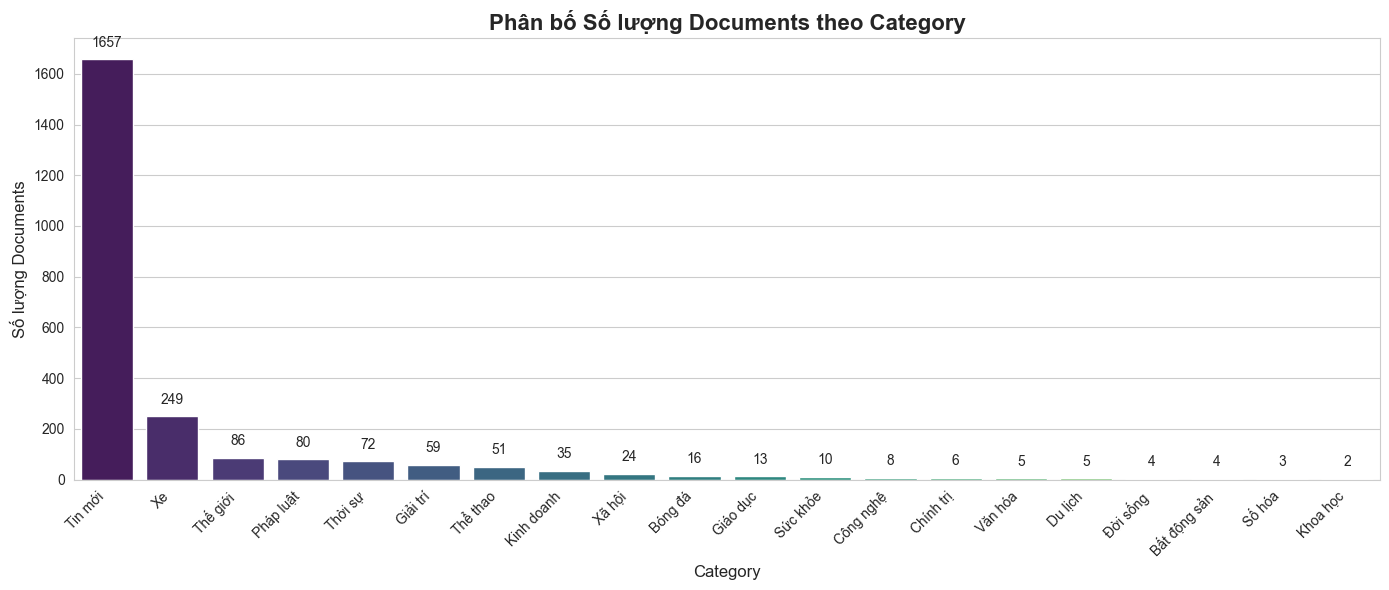


Thống kê Category:
  Tin mới             :  1657 (69.36%)
  Xe                  :   249 (10.42%)
  Thế giới            :    86 ( 3.60%)
  Pháp luật           :    80 ( 3.35%)
  Thời sự             :    72 ( 3.01%)
  Giải trí            :    59 ( 2.47%)
  Thể thao            :    51 ( 2.13%)
  Kinh doanh          :    35 ( 1.47%)
  Xã hội              :    24 ( 1.00%)
  Bóng đá             :    16 ( 0.67%)
  Giáo dục            :    13 ( 0.54%)
  Sức khỏe            :    10 ( 0.42%)
  Công nghệ           :     8 ( 0.33%)
  Chính trị           :     6 ( 0.25%)
  Văn hóa             :     5 ( 0.21%)
  Du lịch             :     5 ( 0.21%)
  Đời sống            :     4 ( 0.17%)
  Bất động sản        :     4 ( 0.17%)
  Số hóa              :     3 ( 0.13%)
  Khoa học            :     2 ( 0.08%)


In [37]:
# --- 1. PHÂN BỐ THEO CATEGORY ---
print("\n--- 1. Phân bố Category ---")
plt.figure(figsize=(14, 6))
category_counts = final_df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Phân bố Số lượng Documents theo Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Số lượng Documents', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(category_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

print(f"\nThống kê Category:")
for cat, count in category_counts.items():
    pct = count/len(final_df)*100
    print(f"  {cat:20s}: {count:5d} ({pct:5.2f}%)")


--- 2. Top 30 Từ Phổ biến Nhất ---


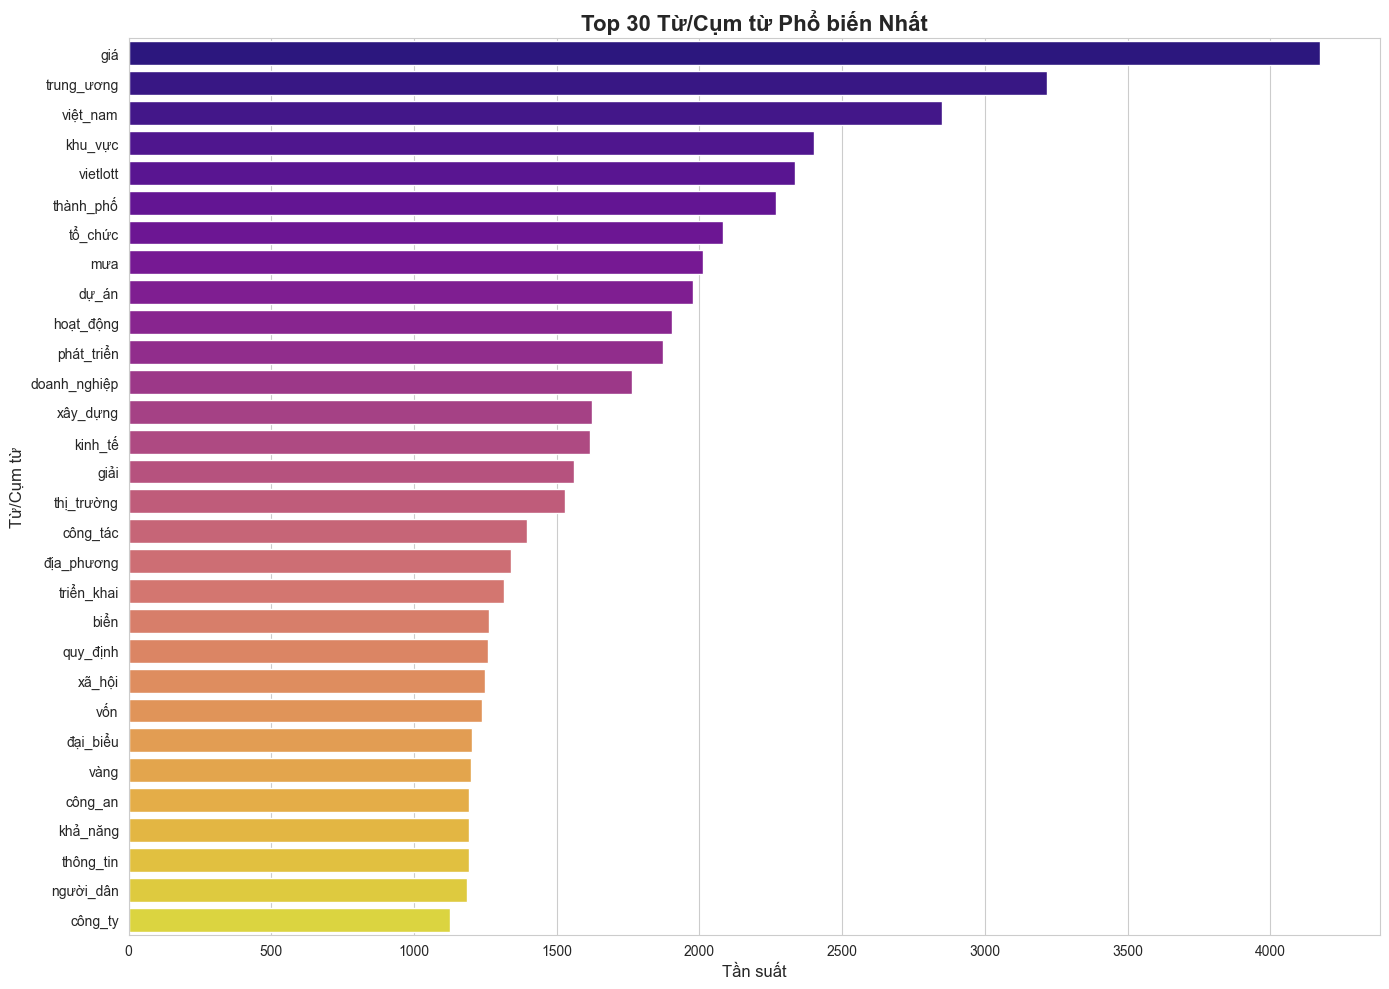


Tổng từ vựng unique: 20,666
Top 10 từ: [('giá', 4175), ('trung_ương', 3219), ('việt_nam', 2851), ('khu_vực', 2400), ('vietlott', 2336), ('thành_phố', 2268), ('tổ_chức', 2082), ('mưa', 2012), ('dự_án', 1976), ('hoạt_động', 1904)]

Bigrams trong top 30: 23
Ví dụ: ['trung_ương', 'việt_nam', 'khu_vực', 'thành_phố', 'tổ_chức', 'dự_án', 'hoạt_động', 'phát_triển', 'doanh_nghiệp', 'xây_dựng']


In [38]:
# --- 2. TOP 30 TỪ PHỔ BIẾN ---
print("\n--- 2. Top 30 Từ Phổ biến Nhất ---")
all_tokens = []
for text in final_df['description'].tolist():
    all_tokens.extend(text.split())

token_counts = Counter(all_tokens)
top_n = 30
most_common = token_counts.most_common(top_n)

tokens, counts = zip(*most_common)
plt.figure(figsize=(14, 10))
sns.barplot(x=list(counts), y=list(tokens), palette="plasma")
plt.title(f'Top {top_n} Từ/Cụm từ Phổ biến Nhất', fontsize=16, fontweight='bold')
plt.xlabel('Tần suất', fontsize=12)
plt.ylabel('Từ/Cụm từ', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTổng từ vựng unique: {len(token_counts):,}")
print(f"Top 10 từ: {most_common[:10]}")

# Kiểm tra bigrams trong top
bigrams_in_top = [w for w, c in most_common if '_' in w]
print(f"\nBigrams trong top {top_n}: {len(bigrams_in_top)}")
if bigrams_in_top:
    print(f"Ví dụ: {bigrams_in_top[:10]}")


--- 3. Phân bố Độ dài Văn bản ---


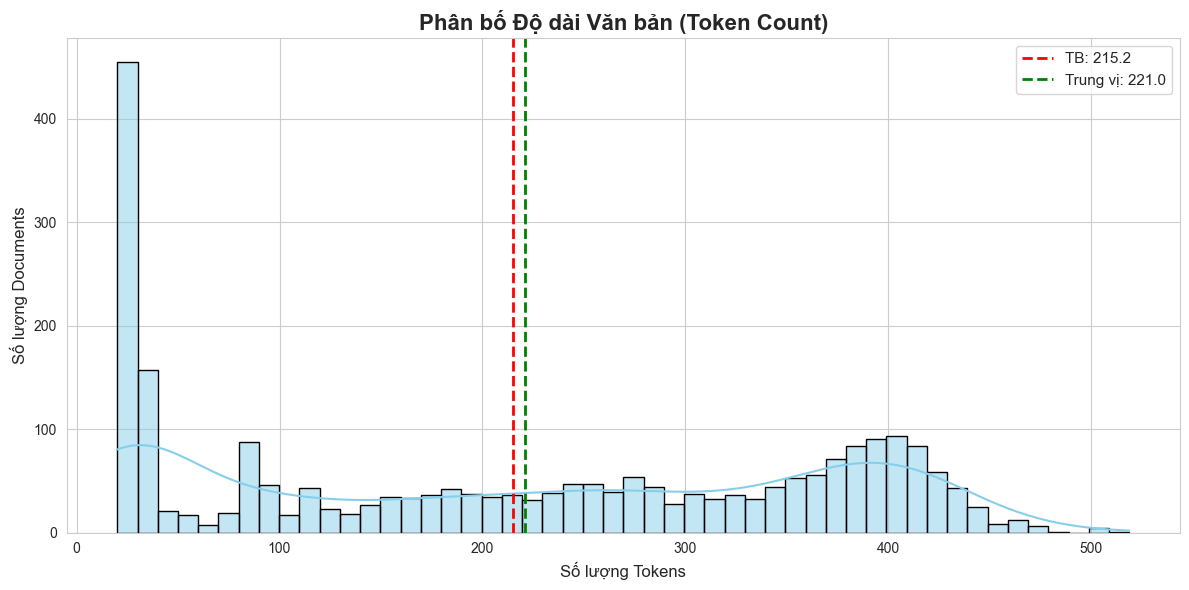


Thống kê độ dài:
count    2389.000000
mean      215.170364
std       150.569101
min        20.000000
25%        37.000000
50%       221.000000
75%       367.000000
max       519.000000
Name: text_length, dtype: float64


In [39]:
# --- 3. PHÂN BỐ ĐỘ DÀI VĂN BẢN ---
print("\n--- 3. Phân bố Độ dài Văn bản ---")
plt.figure(figsize=(12, 6))
sns.histplot(final_df['text_length'], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title('Phân bố Độ dài Văn bản (Token Count)', fontsize=16, fontweight='bold')
plt.xlabel('Số lượng Tokens', fontsize=12)
plt.ylabel('Số lượng Documents', fontsize=12)

mean_len = final_df['text_length'].mean()
median_len = final_df['text_length'].median()
plt.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'TB: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='--', linewidth=2, label=f'Trung vị: {median_len:.1f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nThống kê độ dài:")
print(final_df['text_length'].describe())

In [40]:
# --- 4. TỪ ĐẶC TRƯNG THEO CATEGORY (TF-IDF) ---
print("\n--- 4. Từ Đặc trưng Theo Category (TF-IDF) ---")

category_keywords = {}
for cat in final_df['category'].unique():
    cat_docs = final_df[final_df['category'] == cat]['description'].tolist()

    if len(cat_docs) < 5:
        print(f"\n⚠️ {cat}: Quá ít documents ({len(cat_docs)}), bỏ qua")
        continue

    try:
        vectorizer = TfidfVectorizer(max_features=15, min_df=2)
        tfidf_matrix = vectorizer.fit_transform(cat_docs)
        feature_names = vectorizer.get_feature_names_out()

        # Lấy từ có TF-IDF cao nhất
        avg_tfidf = tfidf_matrix.mean(axis=0).A1
        top_indices = avg_tfidf.argsort()[-10:][::-1]
        top_words = [feature_names[i] for i in top_indices]

        category_keywords[cat] = top_words
        print(f"\n📌 {cat} ({len(cat_docs)} docs):")
        print(f"   {', '.join(top_words)}")
    except Exception as e:
        print(f"\n⚠️ {cat}: Lỗi - {e}")


--- 4. Từ Đặc trưng Theo Category (TF-IDF) ---

📌 Bóng đá (16 docs):
   trận, bóng, việt_nam, philippines, nữ, đội, đấu, thi_đấu, bóng_đá, giải

📌 Tin mới (1657 docs):
   trung_ương, khu_vực, thành_phố, việt_nam, vietlott, tổ_chức, dự_án, hoạt_động, giá, xây_dựng

📌 Xe (249 docs):
   giá, ô_tô, hãng, cập_nhật, dòng, mẫu, xe_máy, chi_tiết, thiết_kế, viết

📌 Giáo dục (13 docs):
   trường, giáo_dục, giáo_viên, dạy, học_sinh, trung_tâm, sở, nhà_trường, sắp_xếp, tổ_chức

📌 Văn hóa (5 docs):
   văn_hóa, di_sản, hoạt_động, chương_trình, tổ_chức, thành_phố, hợp_tác, phát_triển, ban_nhân_dân, việt_nam

⚠️ Số hóa: Quá ít documents (3), bỏ qua

📌 Thể thao (51 docs):
   việt_nam, trận, nữ, thể_thao, philippines, huấn_luyện_viên, bóng, đội, đội_tuyển, myanmar

📌 Xã hội (24 docs):
   xã_hội, trung_ương, phát_triển, thành_phố, đối_tượng, quy_định, tổ_chức, an_sinh, địa_phương, xây_dựng

📌 Thế giới (86 docs):
   trung_quốc, khu_vực, châu_âu, nga, mỹ, quốc_gia, tàu, giá, israel, tổng_thống

📌 Pháp luậ

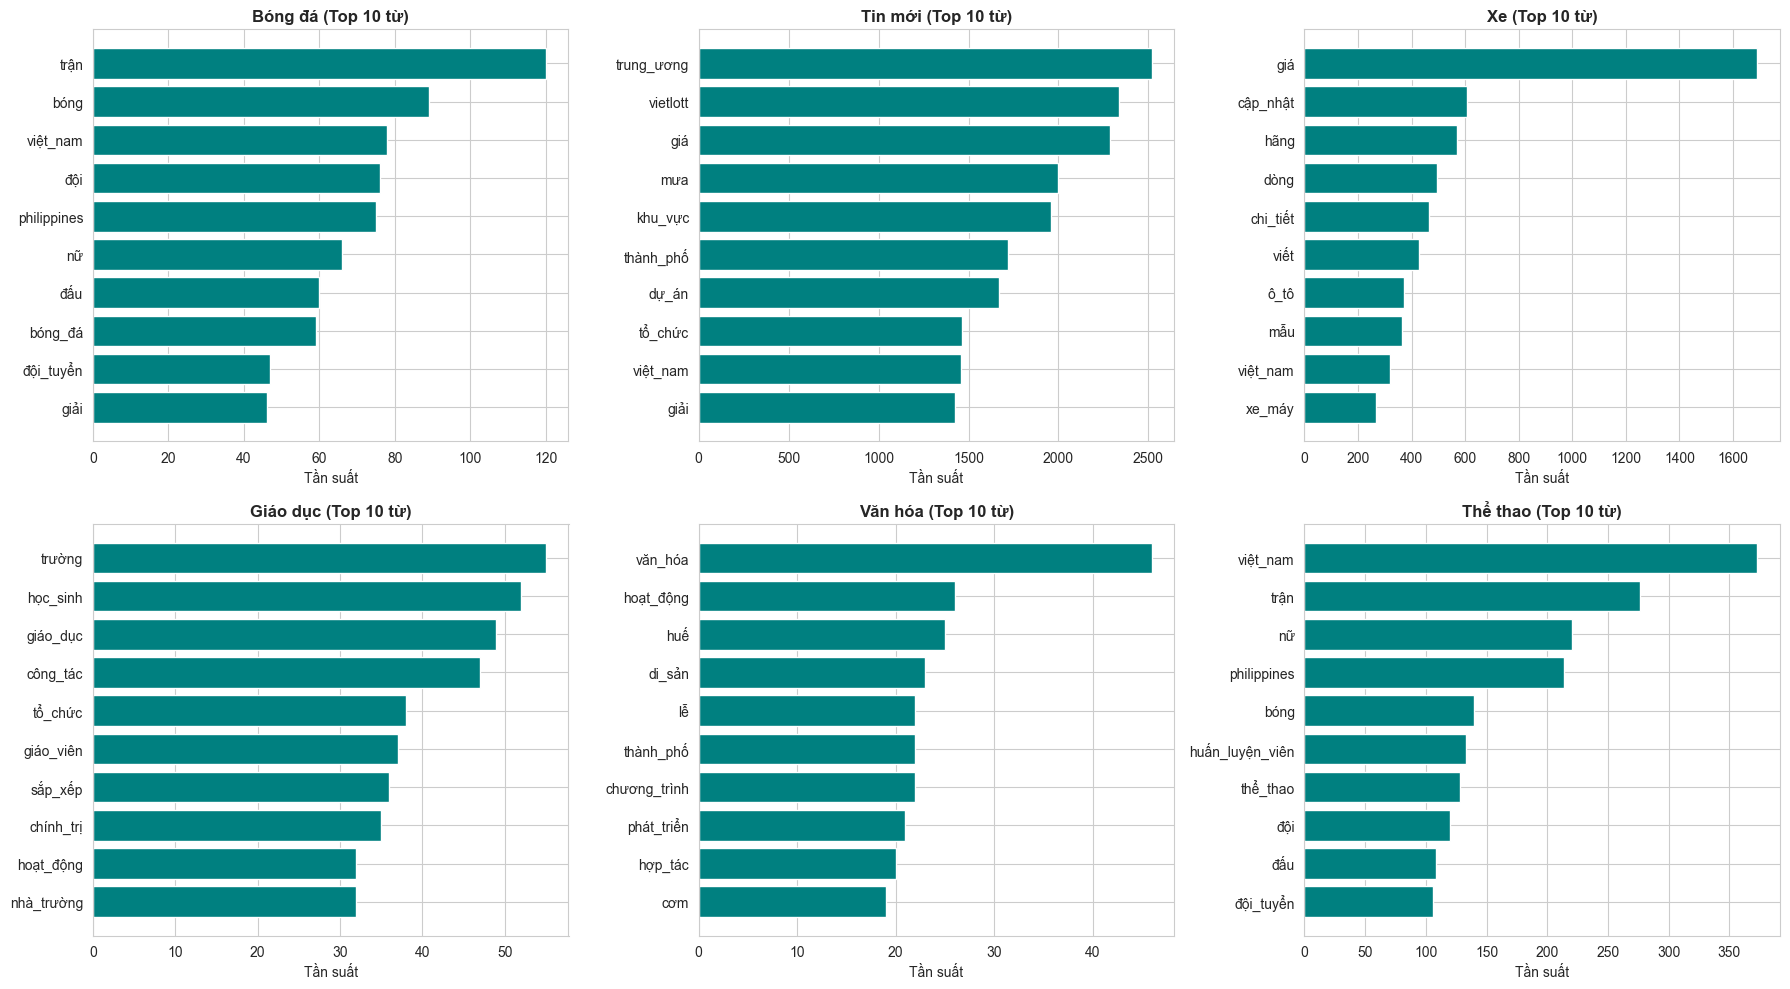

In [41]:
# Vẽ biểu đồ từ đặc trưng
if len(category_keywords) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, (cat, words) in enumerate(list(category_keywords.items())[:6]):
        if idx >= 6:
            break

        cat_docs = final_df[final_df['category'] == cat]['description']
        word_freq = Counter(' '.join(cat_docs).split())
        top_10 = dict(word_freq.most_common(10))

        axes[idx].barh(list(top_10.keys()), list(top_10.values()), color='teal')
        axes[idx].set_title(f'{cat} (Top 10 từ)', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Tần suất', fontsize=10)
        axes[idx].invert_yaxis()

    plt.tight_layout()
    plt.show()

In [44]:
# --- 5. PHÁT HIỆN OUTLIERS ---
print("\n--- 5. Phát hiện Outliers ---")

# Documents quá ngắn
q1 = final_df['text_length'].quantile(0.25)
short_threshold = 40
short_docs = final_df[final_df['text_length'] < short_threshold]
print(f"\nDocuments < {short_threshold} từ: {len(short_docs)} ({len(short_docs)/len(final_df)*100:.2f}%)")

if len(short_docs) > 0:
    print(f"\nVí dụ document ngắn:")
    sample_short = short_docs.iloc[0]
    print(f"  Category: {sample_short['category']}")
    print(f"  Length: {sample_short['text_length']} từ")
    print(f"  Content: {sample_short['description'][:200]}...")

# Documents quá dài
q3 = final_df['text_length'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
long_docs = final_df[final_df['text_length'] > upper_bound]
print(f"\nDocuments > {upper_bound:.0f} từ (outliers): {len(long_docs)} ({len(long_docs)/len(final_df)*100:.2f}%)")

if len(long_docs) > 0:
    print(f"\nVí dụ document dài:")
    sample_long = long_docs.iloc[0]
    print(f"  Category: {sample_long['category']}")
    print(f"  Length: {sample_long['text_length']} từ")
    print(f"  Content: {sample_long['description'][:200]}...")


--- 5. Phát hiện Outliers ---

Documents < 40 từ: 612 (25.62%)

Ví dụ document ngắn:
  Category: Tin mới
  Length: 27 từ
  Content: tin_tức bán_đảo kamchatka bán_đảo kamchatka tin_tức h_động đất khơi nhật_bản tokyo loạt cảnh_báo sóng thần_động đất nhật_bản sóng_thần gấp_rút sơ_tán công_dân_động đất richter rung_chuyển nhật_phát cả...

Documents > 862 từ (outliers): 0 (0.00%)


In [ ]:
# --- 6. KIỂM TRA STOPWORDS/NOISE SÓT LẠI ---
print("\n--- 6. Kiểm tra Noise/Stopwords Sót ---")

# Lưu ý: 'token_counts' phải được định nghĩa từ đoạn EDA trước đó
# Nếu không có, bạn cần đảm bảo đoạn sau đã được chạy:
# all_tokens = []
# for text in final_df['title'].tolist() + final_df['description'].tolist():
#     all_tokens.extend(text.split())
# token_counts = Counter(all_tokens)

# Từ 1 ký tự
single_char = {w: c for w, c in token_counts.most_common(100) if len(w) == 1}
if single_char:
    print(f"\n Từ 1 ký tự trong top 100:")
    print(f"   {single_char}")
else:
    print(f"\n✓ Không có từ 1 ký tự trong top 100")

# Từ chỉ chứa dấu gạch/số
# Cú pháp đã sửa: đóng chuỗi regex và hàm re.match()
noise_pattern = [
    w for w, c in token_counts.most_common(100)
    if (re.match(r'^[_\-]+$', w) or w.upper() in ['MONEY', 'DATE', 'QUANTITY'])
]

if noise_pattern:
    print(f"\n Token đặc biệt trong top 100:")
    for w in noise_pattern:
        print(f"   {w}: {token_counts[w]}")
else:
    print(f"\n✓ Không có token đặc biệt (gạch/DATE/MONEY/QUANTITY) trong top 100.")

# Từ xuất hiện quá ít (có thể là lỗi)
rare_words = {w: c for w, c in token_counts.items() if c == 1}
print(f"\nTừ xuất hiện 1 lần (rare): {len(rare_words):,} ({len(rare_words)/len(token_counts)*100:.2f}%)")


--- 6. Kiểm tra Noise/Stopwords Sót ---

✓ Không có từ 1 ký tự trong top 100

✓ Không có token đặc biệt (gạch/DATE/MONEY/QUANTITY) trong top 100.

Từ xuất hiện 1 lần (rare): 5,031 (24.34%)



--- 7. Phân bố Độ dài Theo Category ---


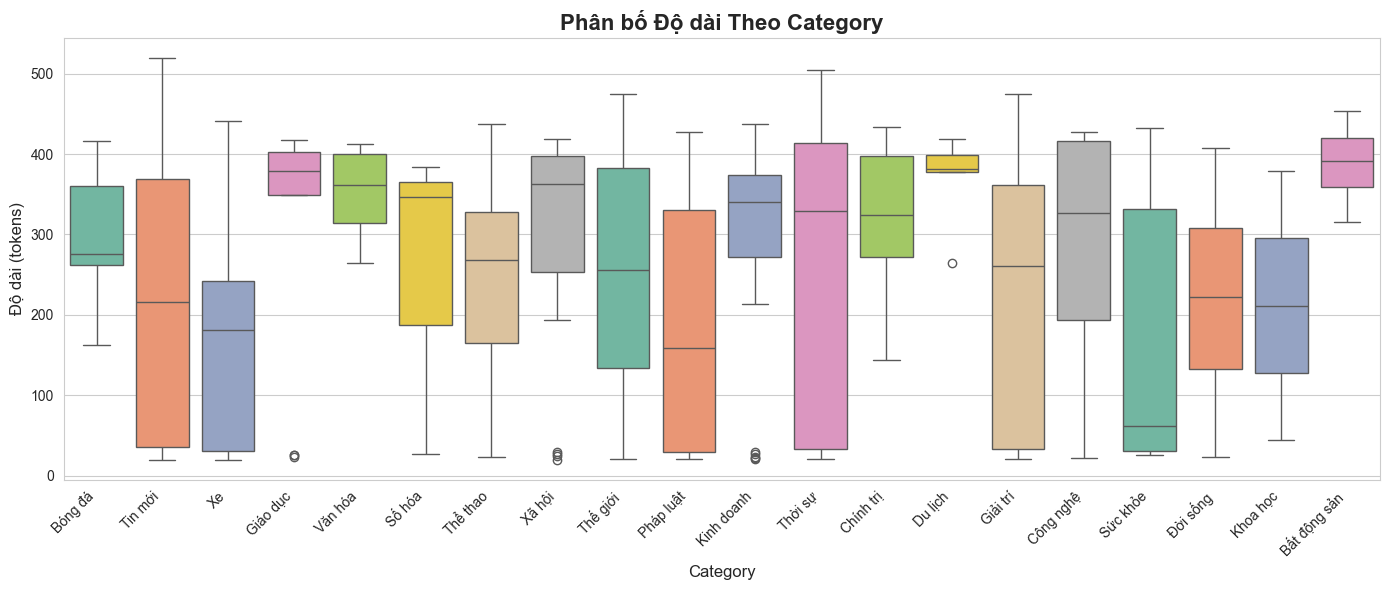


Độ dài trung bình theo Category:
  Bóng đá             : 298.50 ±  76.32
  Tin mới             : 211.85 ± 153.65
  Xe                  : 173.74 ± 118.18
  Giáo dục            : 306.08 ± 161.40
  Văn hóa             : 350.40 ±  61.81
  Số hóa              : 252.67 ± 196.31
  Thể thao            : 240.24 ± 119.47
  Xã hội              : 300.50 ± 138.79
  Thế giới            : 242.53 ± 147.70
  Pháp luật           : 182.20 ± 145.30
  Kinh doanh          : 299.20 ± 126.35
  Thời sự             : 258.76 ± 171.47
  Chính trị           : 317.17 ± 108.04
  Du lịch             : 368.40 ±  60.08
  Giải trí            : 235.88 ± 146.79
  Công nghệ           : 290.38 ± 150.71
  Sức khỏe            : 164.10 ± 168.37
  Đời sống            : 218.50 ± 162.68
  Khoa học            : 211.50 ± 236.88
  Bất động sản        : 387.75 ±  57.95


In [46]:
# --- 7. PHÂN BỐ ĐỘ DÀI THEO CATEGORY ---
print("\n--- 7. Phân bố Độ dài Theo Category ---")

plt.figure(figsize=(14, 6))
sns.boxplot(data=final_df, x='category', y='text_length', palette='Set2')
plt.title('Phân bố Độ dài Theo Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Độ dài (tokens)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nĐộ dài trung bình theo Category:")
for cat in final_df['category'].unique():
    cat_len = final_df[final_df['category'] == cat]['text_length']
    print(f"  {cat:20s}: {cat_len.mean():6.2f} ± {cat_len.std():6.2f}")


In [47]:
# --- 8. PHÂN TÍCH OVERLAP GIỮA CÁC CATEGORY ---
print("\n--- 8. Phân tích Overlap Từ vựng Giữa Categories ---")

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

categories = final_df['category'].unique()
category_vocabs = {}

for cat in categories:
    cat_docs = final_df[final_df['category'] == cat]['description']
    vocab = set(' '.join(cat_docs).split())
    category_vocabs[cat] = vocab

print(f"\nKích thước từ vựng theo Category:")
for cat, vocab in category_vocabs.items():
    print(f"  {cat:20s}: {len(vocab):6,} từ unique")

# Tính Jaccard similarity
if len(categories) > 1:
    print(f"\nJaccard Similarity giữa các Categories:")
    for i, cat1 in enumerate(categories):
        for cat2 in categories[i+1:]:
            sim = jaccard_similarity(category_vocabs[cat1], category_vocabs[cat2])
            print(f"  {cat1:15s} vs {cat2:15s}: {sim:.4f}")


--- 8. Phân tích Overlap Từ vựng Giữa Categories ---

Kích thước từ vựng theo Category:
  Bóng đá             :  1,170 từ unique
  Tin mới             : 15,193 từ unique
  Xe                  :  3,941 từ unique
  Giáo dục            :  1,015 từ unique
  Văn hóa             :    483 từ unique
  Số hóa              :    238 từ unique
  Thể thao            :  1,613 từ unique
  Xã hội              :  1,383 từ unique
  Thế giới            :  3,228 từ unique
  Pháp luật           :  2,539 từ unique
  Kinh doanh          :  2,418 từ unique
  Thời sự             :  2,081 từ unique
  Chính trị           :    505 từ unique
  Du lịch             :    486 từ unique
  Giải trí            :  2,978 từ unique
  Công nghệ           :    756 từ unique
  Sức khỏe            :    615 từ unique
  Đời sống            :    361 từ unique
  Khoa học            :    215 từ unique
  Bất động sản        :    552 từ unique

Jaccard Similarity giữa các Categories:
  Bóng đá         vs Tin mới        : 0.0573
  Bón


--- 9. Word Clouds (Top categories) ---


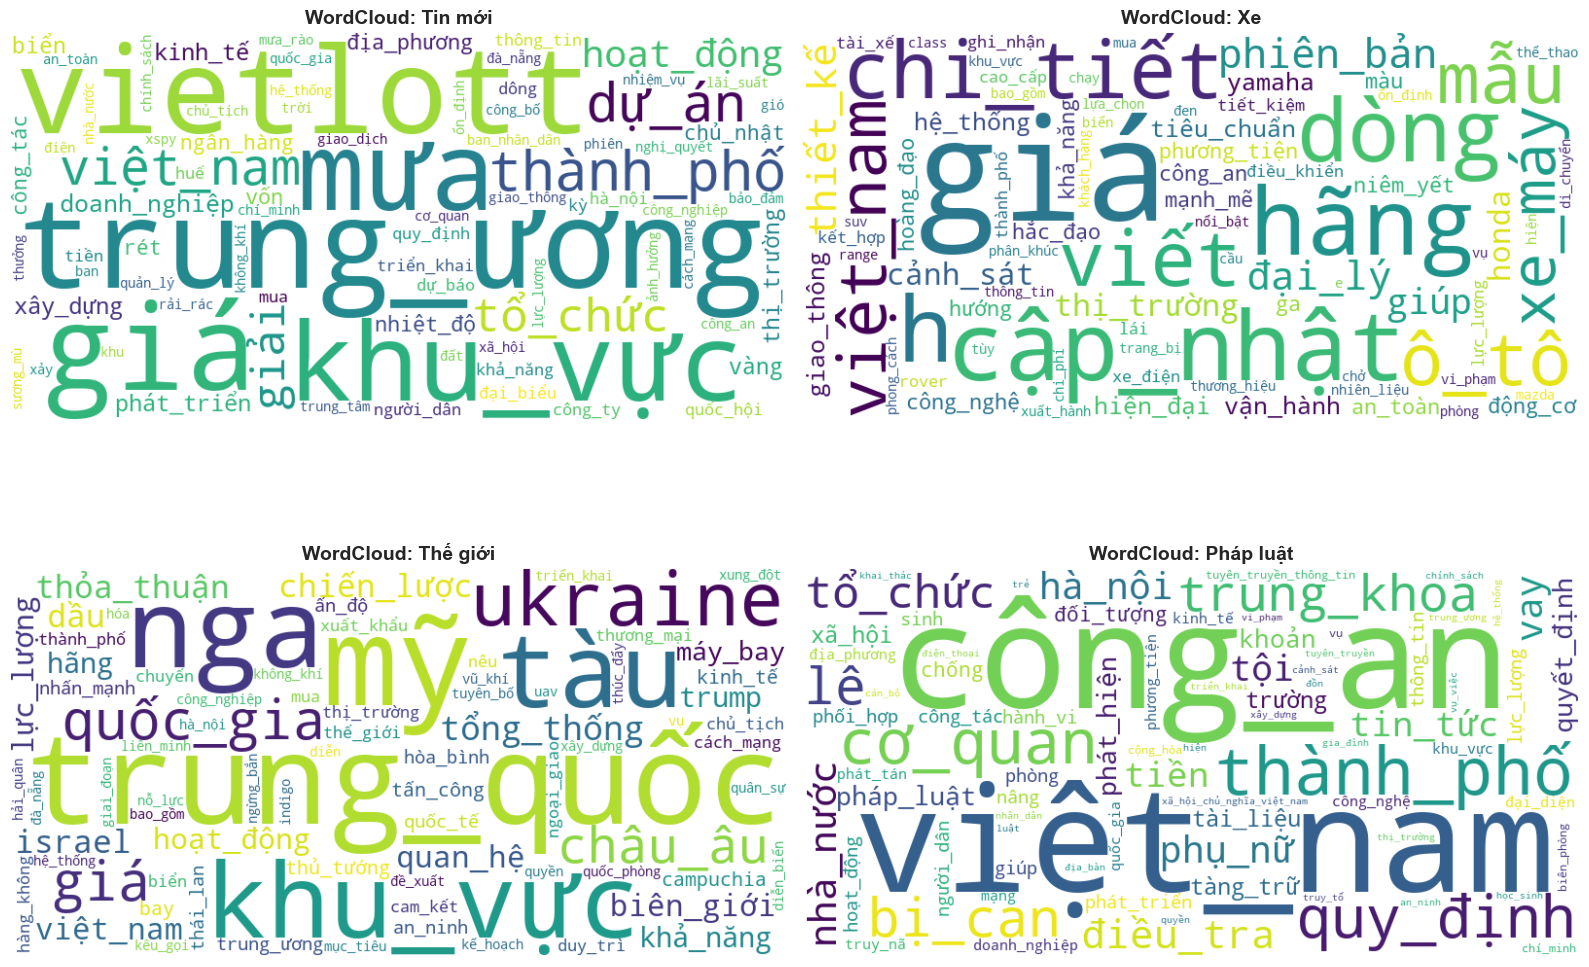

✓ Đã tạo WordClouds


In [ ]:
# --- 9. WORDCLOUD CHO TỪNG CATEGORY ---
print("\n--- 9. Word Clouds (Top categories) ---")

try:
    from wordcloud import WordCloud

    top_cats = final_df['category'].value_counts().head(4).index

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, cat in enumerate(top_cats):
        cat_text = ' '.join(final_df[final_df['category'] == cat]['description'])

        wc = WordCloud(
            background_color='white',
            max_words=80,
            width=800,
            height=400,
            colormap='viridis',
            collocations=False
        ).generate(cat_text)

        axes[idx].imshow(wc, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'WordCloud: {cat}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    print("✓ Đã tạo WordClouds")
except ImportError:
    print(" Cần cài wordcloud: pip install wordcloud")

In [51]:
# --- 10. TÓM TẮT CUỐI CÙNG ---
print("\n" + "="*70)
print("TÓM TẮT KẾT QUẢ XỬ LÝ DỮ LIỆU")
print("="*70)

print(f"\n TỔNG QUAN:")
print(f"  • Documents gốc: {df_original_len:,}")
print(f"  • Documents cuối: {len(final_df):,}")
print(f"  • Tỷ lệ giữ lại: {len(final_df)/df_original_len*100:.2f}%")
print(f"  • Số categories: {final_df['category'].nunique()}")

print(f"\n THỐNG KÊ VĂN BẢN:")
print(f"  • Độ dài TB: {final_df['text_length'].mean():.2f} từ")
print(f"  • Độ dài min: {final_df['text_length'].min()}")
print(f"  • Độ dài max: {final_df['text_length'].max()}")
print(f"  • Từ vựng unique: {len(token_counts):,}")
print(f"  • Bigrams found: {len([w for w in token_counts if '_' in w]):,}")



print("\n" + "="*70)
print("HOÀN THÀNH XỬ LÝ & PHÂN TÍCH!")
print("="*70)


TÓM TẮT KẾT QUẢ XỬ LÝ DỮ LIỆU

 TỔNG QUAN:
  • Documents gốc: 3,450
  • Documents cuối: 2,389
  • Tỷ lệ giữ lại: 69.25%
  • Số categories: 20

 THỐNG KÊ VĂN BẢN:
  • Độ dài TB: 215.17 từ
  • Độ dài min: 20
  • Độ dài max: 519
  • Từ vựng unique: 20,666
  • Bigrams found: 14,590

HOÀN THÀNH XỬ LÝ & PHÂN TÍCH!


BERTOPIC

In [50]:
!pip install bertopic
!pip install umap-learn
!pip install hdbscan
!pip install sentence-transformers
!pip install plotly


In [52]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
import os

In [53]:
OUTPUT_CSV = "C:\\Users\\PC\\Desktop\\BERTopic Model\\data\\02_processed\\final_data.csv"
EMBEDDINGS_PATH = "C:\\Users\\PC\\Desktop\\BERTopic Model\\data\\03_embeddings\\document_embeddings.npy"
MODEL_PATH = "C:\\Users\\PC\\Desktop\\BERTopic Model\\models\\bertopic_model_colab"
RESULTS_PATH = "C:\\Users\\PC\\Desktop\\BERTopic Model\\models.bertopic.csv"

In [54]:
# ===== 1. LOAD DỮ LIỆU ĐÃ XỬ LÝ =====
print("="*70)
print("BƯỚC 1: LOAD DỮ LIỆU")
print("="*70)

final_df = pd.read_csv(OUTPUT_CSV)
print(f"✓ Loaded {len(final_df)} documents")
print(f"✓ Columns: {list(final_df.columns)}")

# Tạo documents để train (title + description)
docs = (final_df['description']).tolist()

print(f"\nThống kê documents:")
doc_lengths = [len(doc.split()) for doc in docs]
print(f"  • Độ dài TB: {np.mean(doc_lengths):.2f} từ")
print(f"  • Độ dài min: {np.min(doc_lengths)}")
print(f"  • Độ dài max: {np.max(doc_lengths)}")


BƯỚC 1: LOAD DỮ LIỆU
✓ Loaded 2389 documents
✓ Columns: ['description', 'category']

Thống kê documents:
  • Độ dài TB: 215.17 từ
  • Độ dài min: 20
  • Độ dài max: 519


In [55]:
# ===== 2. VECTOR HÓA (EMBEDDINGS) =====
print("\n" + "="*70)
print("BƯỚC 2: VECTOR HÓA")
print("="*70)

# ✅ QUAN TRỌNG: Dùng MỘT embedding model duy nhất xuyên suốt
EMBEDDING_MODEL_NAME = "keepitreal/vietnamese-sbert"

if os.path.exists(EMBEDDINGS_PATH):
    print(f"✓ Tải embeddings từ: {EMBEDDINGS_PATH}")
    embeddings = np.load(EMBEDDINGS_PATH)
    print(f"✓ Shape: {embeddings.shape}")
else:
    print(f"⏳ Đang tính embeddings bằng {EMBEDDING_MODEL_NAME}...")
    embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
    embeddings = embedding_model.encode(
        docs,
        show_progress_bar=True,
        batch_size=32
    )

    np.save(EMBEDDINGS_PATH, embeddings)
    print(f"✓ Đã lưu embeddings: {EMBEDDINGS_PATH}")
    print(f"✓ Shape: {embeddings.shape}")



BƯỚC 2: VECTOR HÓA
⏳ Đang tính embeddings bằng keepitreal/vietnamese-sbert...


Batches:   0%|          | 0/75 [00:00<?, ?it/s]

✓ Đã lưu embeddings: C:\Users\PC\Desktop\BERTopic Model\data\03_embeddings\document_embeddings.npy
✓ Shape: (2389, 768)


In [56]:
# ===== 3. ĐỊNH NGHĨA HDBSCAN TÙY CHỈNH (SỬA LỖI PREDICT) =====
print("\n" + "="*70)
print("BƯỚC 3: ĐỊNH NGHĨA CLUSTERING")
print("="*70)

class ImprovedCosineHDBSCAN:
    """
    HDBSCAN với cosine distance và khả năng predict cho dữ liệu mới
    """
    def __init__(self, min_cluster_size=15, cluster_selection_method='eom', prediction_data=True):
        self.min_cluster_size = min_cluster_size
        self.cluster_selection_method = cluster_selection_method
        self.prediction_data = prediction_data
        self.model = None
        self.training_data = None

    def fit(self, X, y=None):
        X = np.array(X, dtype=np.float64)
        self.training_data = X  # ✅ Lưu dữ liệu training

        # Tính ma trận khoảng cách cosine
        distance_matrix = cosine_distances(X)

        self.model = HDBSCAN(
            min_cluster_size=self.min_cluster_size,
            metric='precomputed',
            cluster_selection_method=self.cluster_selection_method,
            prediction_data=self.prediction_data
        )

        self.model.fit(distance_matrix)
        self.labels_ = self.model.labels_
        self.probabilities_ = self.model.probabilities_
        return self

    def predict(self, X):
        """
        Dự đoán nhãn cho dữ liệu mới
        """
        if self.training_data is None:
            raise ValueError("Model chưa được fit!")

        X = np.array(X, dtype=np.float64)

        # Tính khoảng cách từ dữ liệu mới tới training data
        distances = cosine_distances(X, self.training_data)

        # Gán nhãn của điểm gần nhất (simple but effective)
        nearest_indices = distances.argmin(axis=1)
        predicted_labels = self.labels_[nearest_indices]

        return predicted_labels

print("✓ Đã định nghĩa ImprovedCosineHDBSCAN")


BƯỚC 3: ĐỊNH NGHĨA CLUSTERING
✓ Đã định nghĩa ImprovedCosineHDBSCAN


Với topic modelling, cần có trực quan hoá bằng Wordclouds. Sau khi phân cụm dựa trên đặc trưng văn bản thành các nhóm, cần sinh caption cho mỗi nhóm (có thể sử dụng spacy, xem thêm trong tài liệu tham khảo số 2). Đánh giá kết quả dựa trên compactness và separation nhưng cần dựa trên khoảng cách cosine thay vì khoảng cách Euclide mặc định, hoặc có thể bổ sung thêm minimum edit distance (Levenshtein).


In [57]:
# ===== 4. CẤU HÌNH UMAP VÀ HDBSCAN =====
print("\n" + "="*70)
print("BƯỚC 4: CẤU HÌNH HYPERPARAMETERS")
print("="*70)

n_docs = len(docs)
print(f"Số lượng documents: {n_docs}")

# Điều chỉnh n_neighbors theo dataset size
n_neighbors = 30
n_components = 15
min_cluster_size = 10
min_samples = 5

print(f"\nHyperparameters được chọn:")
print(f"  • UMAP n_neighbors: {n_neighbors}")
print(f"  • UMAP n_components: {n_components}")
print(f"  • HDBSCAN min_cluster_size: {min_cluster_size}")

umap_model = UMAP(
    n_neighbors=30,
    n_components=15,
    min_dist=0.0,
    metric="euclidean",
    random_state=42,
    verbose=True
)


hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric="euclidean",
    algorithm="best",
    cluster_selection_method="eom",
    prediction_data=True
)

# Vectorizer tùy chỉnh cho tiếng Việt (đã tokenize)
vectorizer_model = CountVectorizer(
    token_pattern=r"(?u)\b[\w_-]+\b",  # Giữ dấu gạch dưới trong bigrams
    min_df=3,  # Từ phải xuất hiện ít nhất 3 documents
    max_df=0.8  # Loại từ xuất hiện >80% documents (quá chung)
)
print("✓ Đã cấu hình các components")


BƯỚC 4: CẤU HÌNH HYPERPARAMETERS
Số lượng documents: 2389

Hyperparameters được chọn:
  • UMAP n_neighbors: 30
  • UMAP n_components: 15
  • HDBSCAN min_cluster_size: 10
✓ Đã cấu hình các components


In [58]:
from sklearn.preprocessing import normalize

In [59]:
# ===== 5. XÂY DỰNG VÀ TRAIN MÔ HÌNH =====
print("\n" + "="*70)
print("BƯỚC 5: TRAIN MÔ HÌNH BERTOPIC")
print("="*70)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="multilingual",
    calculate_probabilities=True,
    nr_topics="auto",
    verbose=True
)


embeddings = embeddings.astype(np.float64)
embeddings_norm = normalize(embeddings, norm="l2")

print("⏳ Đang train mô hình (có thể mất vài phút)...")
topics, probs = topic_model.fit_transform(
    docs,
    embeddings=embeddings_norm
)
print("\n" + "="*70)
print("KẾT QUẢ MÔ HÌNH")
print("="*70)

num_topics = len(set(topics)) - (1 if -1 in topics else 0)
num_outliers = sum(1 for t in topics if t == -1)
outlier_pct = num_outliers / len(topics) * 100

print(f"\n📊 TỔNG QUAN:")
print(f"  • Số topics tìm được: {num_topics}")
print(f"  • Số documents: {len(docs)}")
print(f"  • Outliers (-1): {num_outliers} ({outlier_pct:.2f}%)")

if outlier_pct > 20:
    print(f"\n⚠️ CẢNH BÁO: {outlier_pct:.1f}% outliers quá cao!")
    print(f"   → Nên giảm min_cluster_size xuống {max(5, min_cluster_size-5)}")
elif outlier_pct < 5:
    print(f"\n✓ Tỷ lệ outliers tốt ({outlier_pct:.2f}%)")

# Hiển thị topic info
topic_info = topic_model.get_topic_info()
print(f"\n📋 Top 10 Topics (theo kích thước):")
print(topic_info.head(11)[['Topic', 'Count', 'Name']])

2025-12-19 23:54:34,297 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



BƯỚC 5: TRAIN MÔ HÌNH BERTOPIC
⏳ Đang train mô hình (có thể mất vài phút)...
UMAP(min_dist=0.0, n_components=15, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Fri Dec 19 23:54:34 2025 Construct fuzzy simplicial set
Fri Dec 19 23:54:39 2025 Finding Nearest Neighbors
Fri Dec 19 23:54:44 2025 Finished Nearest Neighbor Search
Fri Dec 19 23:54:46 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Dec 19 23:54:52 2025 Finished embedding


2025-12-19 23:54:52,802 - BERTopic - Dimensionality - Completed ✓
2025-12-19 23:54:52,805 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-19 23:54:53,314 - BERTopic - Cluster - Completed ✓
2025-12-19 23:54:53,314 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-19 23:54:53,670 - BERTopic - Representation - Completed ✓
2025-12-19 23:54:53,671 - BERTopic - Topic reduction - Reducing number of topics
2025-12-19 23:54:53,692 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-19 23:54:54,032 - BERTopic - Representation - Completed ✓
2025-12-19 23:54:54,034 - BERTopic - Topic reduction - Reduced number of topics from 66 to 30



KẾT QUẢ MÔ HÌNH

📊 TỔNG QUAN:
  • Số topics tìm được: 29
  • Số documents: 2389
  • Outliers (-1): 272 (11.39%)

📋 Top 10 Topics (theo kích thước):
    Topic  Count                                        Name
0      -1    272  -1_vietlott_trung_ương_chủ_nhật_phát_triển
1       0   1077       0_trung_ương_tổ_chức_dự_án_phát_triển
2       1    183                    1_giá_hãng_cập_nhật_dòng
3       2    154             2_giải_thưởng_chủ_nhật_vietlott
4       3    107          3_cảnh_sát_cháy_giao_thông_vi_phạm
5       4     87                     4_mưa_nhiệt_độ_rét_dông
6       5     58          5_ngân_hàng_lãi_suất_tỷ_giá_kỳ_hạn
7       6     46                         6_vàng_giá_mua_nhẫn
8       7     32                    7_dầu_giá_thùng_xăng_dầu
9       8     31         8_doanh_nghiệp_đăng_ký_thành_lập_kỳ
10      9     30                       9_bé_chó_gái_gia_đình


In [60]:
# ===== 6. LƯU MÔ HÌNH =====
print("\n" + "="*70)
print("BƯỚC 6: LƯU MÔ HÌNH")
print("="*70)

# Lưu mô hình
topic_model.save(
    MODEL_PATH,
    serialization="pickle",
    save_embedding_model=False
)
print(f"✓ Đã lưu model: {MODEL_PATH}")

# Lưu kết quả
results_df = final_df.copy()
results_df['topic'] = topics

# Xác suất của topic được gán
topic_probs = [
    probs[i][t] if t != -1 else 0.0
    for i, t in enumerate(topics)
]

results_df['topic_probability'] = topic_probs

results_df.to_csv(RESULTS_PATH, index=False, encoding='utf-8-sig')
print(f"✓ Đã lưu results: {RESULTS_PATH}")

# Lưu topic info
topic_info.to_csv(
    RESULTS_PATH.replace('.csv', '_topic_info.csv'),
    index=False,
    encoding='utf-8-sig'
)
print(f"✓ Đã lưu topic info")

2025-12-19 23:54:57,228 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



BƯỚC 6: LƯU MÔ HÌNH
✓ Đã lưu model: C:\Users\PC\Desktop\BERTopic Model\models\bertopic_model_colab
✓ Đã lưu results: C:\Users\PC\Desktop\BERTopic Model\models.bertopic.csv
✓ Đã lưu topic info


“BERTopic trả về ma trận xác suất biểu diễn mức độ liên quan của mỗi văn bản với từng chủ đề. Trong nghiên cứu này, chúng tôi sử dụng xác suất cao nhất tương ứng với chủ đề được gán cho mỗi văn bản để biểu diễn độ tin cậy của kết quả phân cụm.”

In [63]:
# ===== 7. ĐÁNH GIÁ CHẤT LƯỢNG =====
print("\n" + "="*70)
print("BƯỚC 7: ĐÁNH GIÁ CHẤT LƯỢNG")
print("="*70)

import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score

labels = np.array(topics)
valid_mask = labels != -1


if valid_mask.sum() > 1 and len(set(labels[valid_mask])) > 1:

    eval_embeddings = embeddings_norm[valid_mask]
    eval_labels = labels[valid_mask]
    sil_score = silhouette_score(
        eval_embeddings,
        eval_labels,
        metric="cosine"
    )
    ch_score = calinski_harabasz_score(
        eval_embeddings,
        eval_labels
    )

    print(f"\n METRICS:")
    print(f"  • Silhouette Score (cosine): {sil_score:.4f}")
    print(f"    - Gần 1: cụm tách biệt tốt")
    print(f"    - Gần 0: cụm chồng lấn")

    print(f"\n  • Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"    - Cao hơn → clusters tách biệt rõ hơn")
else:
    print(" Không đủ clusters hợp lệ để đánh giá")
topic_counts = topic_info[topic_info['Topic'] != -1].sort_values('Count', ascending=False)
print(f"\n PHÂN BỐ TOPICS:")
print(f"  • Topic lớn nhất: {topic_counts.iloc[0]['Count']} docs")
print(f"  • Topic nhỏ nhất: {topic_counts.iloc[-1]['Count']} docs")
print(f"  • Trung bình: {topic_counts['Count'].mean():.1f} docs/topic")

largest_topic_pct = topic_counts.iloc[0]['Count'] / len(docs) * 100
if largest_topic_pct > 30:
    print(f"\n Topic lớn nhất chiếm {largest_topic_pct:.1f}% - có thể quá chung chung")





BƯỚC 7: ĐÁNH GIÁ CHẤT LƯỢNG

 METRICS:
  • Silhouette Score (cosine): 0.0726
    - Gần 1: cụm tách biệt tốt
    - Gần 0: cụm chồng lấn

  • Calinski-Harabasz Score: 26.27
    - Cao hơn → clusters tách biệt rõ hơn

 PHÂN BỐ TOPICS:
  • Topic lớn nhất: 1077 docs
  • Topic nhỏ nhất: 10 docs
  • Trung bình: 73.0 docs/topic

 Topic lớn nhất chiếm 45.1% - có thể quá chung chung


In [66]:
CAPTION_PATH = os.path.join(r"C:\Users\PC\Desktop\BERTopic Model\reports\figures", 'topic_captions_final.csv')

In [67]:
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer

# Định nghĩa hàm khắc phục lỗi 'verbose'
def new_encode_method(self, documents, **kwargs):
    kwargs.pop('verbose', None)
    kwargs.pop('method', None)
    return self.encode(documents, **kwargs)

# --- Khắc phục lỗi và Gán lại Mô hình Nhúng ---
print("\n--- Đang khắc phục lỗi và Sinh Caption ---")
EMBEDDING_MODEL_NAME = "keepitreal/vietnamese-sbert"
new_embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
setattr(new_embedding_model, 'embed_documents', new_encode_method.__get__(new_embedding_model))
setattr(new_embedding_model, 'embed_words', new_encode_method.__get__(new_embedding_model))
topic_model.embedding_model = new_embedding_model
print("✓ Khắc phục mô hình nhúng thành công và gán lại.")

# --- Chạy Update Topics ---
representation_model = KeyBERTInspired()
topic_model.update_topics(docs, topic_model.topics_, representation_model=representation_model)
print("✓ Cập nhật topics thành công.")

# --- XUẤT KẾT QUẢ VÀ LƯU FILE ---
topic_info_with_labels = topic_model.get_topic_info()

# Lấy nhãn thủ công
topic_representations = topic_model.topic_representations_
caption_data = []
for topic_id, representations in topic_representations.items():
    if topic_id != -1:
        # Lấy top 3 từ làm Caption
        caption = ", ".join([w for w, _ in representations[:3]])
        caption_data.append({'Topic': topic_id, 'Caption': caption}) # Đặt tên là Caption luôn ở đây
    else:
        caption_data.append({'Topic': -1, 'Caption': "Nhiễu/Không xác định"})

caption_df = pd.DataFrame(caption_data)

# Gộp nhãn
final_caption_output = pd.merge(topic_info_with_labels, caption_df, on='Topic', how='left')

# Xử lý các giá trị NaN nếu có (phòng trường hợp merge không khớp)
final_caption_output['Caption'] = final_caption_output['Caption'].fillna("Nhiễu/Không xác định")

# Chọn lọc các cột cần thiết (Lưu ý: dùng đúng tên cột hiện có)
final_caption_output = final_caption_output[['Topic', 'Count', 'Name', 'Caption', 'Representation', 'Representative_Docs']]

# Lưu file
final_caption_output.to_csv(CAPTION_PATH, index=False, encoding='utf-8-sig')

print(f"✓ Hoàn thành sinh Caption. Đã lưu tại: {CAPTION_PATH}")
print("\nTop 5 Chủ đề với Caption mới:")
print(final_caption_output[final_caption_output['Topic'] != -1].head())


--- Đang khắc phục lỗi và Sinh Caption ---
✓ Khắc phục mô hình nhúng thành công và gán lại.
✓ Cập nhật topics thành công.
✓ Hoàn thành sinh Caption. Đã lưu tại: C:\Users\PC\Desktop\BERTopic Model\reports\figures\topic_captions_final.csv

Top 5 Chủ đề với Caption mới:
   Topic  Count                                     Name  \
1      0   1077    0_phát_triển_quốc_hội_quốc_phòng_trận   
2      1    183        1_đại_lý_phiên_bản_phân_khúc_ô_tô   
3      2    154  2_giải_jackpot_quảng_ngãi_độc_đắc_vé_số   
4      3    107             3_xử_phạt_phạt_kiểm_soát_cồn   
5      4     87            4_mưa_dông_mưa_đá_mưa_mưa_rào   

                             Caption  \
1   phát_triển, quốc_hội, quốc_phòng   
2       đại_lý, phiên_bản, phân_khúc   
3  giải_jackpot, quảng_ngãi, độc_đắc   
4           xử_phạt, phạt, kiểm_soát   
5              mưa_dông, mưa_đá, mưa   

                                      Representation  \
1  [phát_triển, quốc_hội, quốc_phòng, trận, ban_n...   
2  [đại_lý, phiên

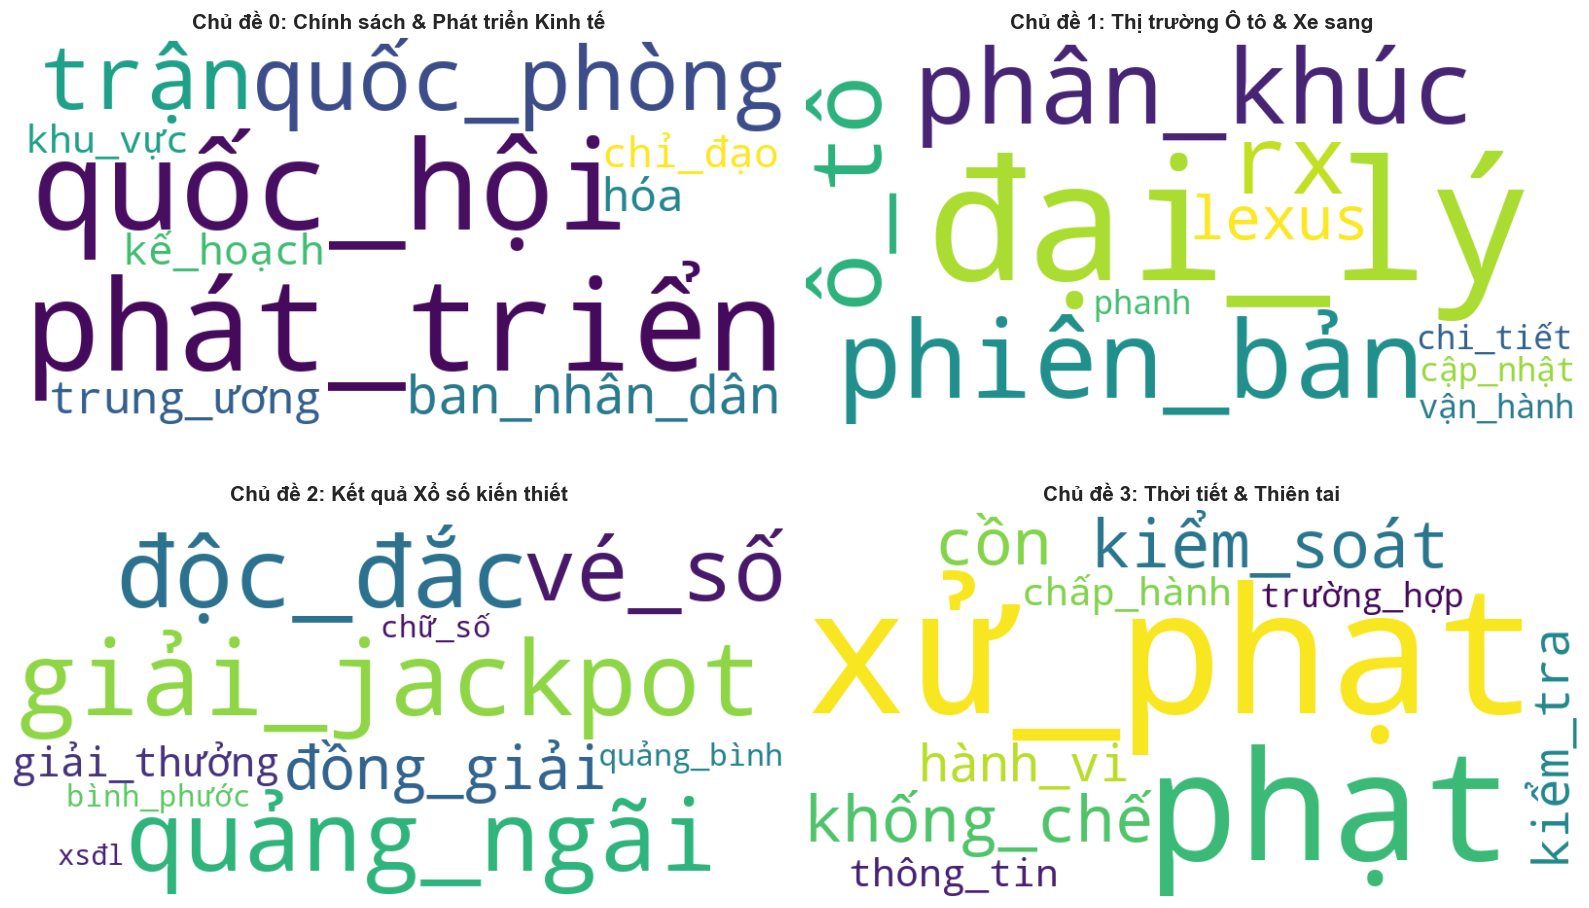

✓ Đã lưu file kết quả với tên riêng tại: C:\Users\PC\Desktop\BERTopic Model\reports\figures\topic_captions_final.csv


In [68]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# --- BƯỚC 1: ĐỊNH NGHĨA TÊN RIÊNG (CUSTOM LABELS) ---
# Dựa trên phân tích nội dung thực tế của bạn
custom_labels = {
    -1: "Nhiễu/Không xác định",
    0: "Chính sách & Phát triển Kinh tế",
    1: "Thị trường Ô tô & Xe sang",
    2: "Kết quả Xổ số kiến thiết",
    3: "Thời tiết & Thiên tai"
}

# Gán nhãn vào mô hình BERTopic
topic_model.set_topic_labels(custom_labels)

# --- BƯỚC 2: CẬP NHẬT DATAFRAME KẾT QUẢ ---
df_topic_info = topic_model.get_topic_info()
# Lấy các cột quan trọng, 'CustomName' là cột chứa nhãn bạn vừa set_topic_labels
final_caption_output = df_topic_info[['Topic', 'Count', 'CustomName', 'Representation']].copy()
final_caption_output = final_caption_output.rename(columns={'CustomName': 'Ten_Chu_De'})

# --- BƯỚC 3: VẼ WORDCLOUD VỚI TÊN RIÊNG ---
top_4_topics = final_caption_output[final_caption_output['Topic'] != -1].head(4)['Topic'].values

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, t_id in enumerate(top_4_topics):
    # Lấy trọng số c-TF-IDF từ mô hình
    words = dict(topic_model.get_topic(t_id))

    wc = WordCloud(background_color="white", max_words=50, width=800, height=400, colormap='viridis')
    wc.generate_from_frequencies(words)

    # Truy xuất tên riêng đã đặt từ cột 'Ten_Chu_De'
    topic_title = final_caption_output.loc[final_caption_output['Topic'] == t_id, 'Ten_Chu_De'].values[0]

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Chủ đề {t_id}: {topic_title}", fontsize=15, fontweight='bold')
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Lưu kết quả cuối cùng
final_caption_output.to_csv(CAPTION_PATH, index=False, encoding='utf-8-sig')
print(f"✓ Đã lưu file kết quả với tên riêng tại: {CAPTION_PATH}")

In [69]:
embeddings_np = np.array(embeddings)
topics_np = np.array(topics)

# Loại outliers
valid_mask = topics_np != -1
embeddings_valid = embeddings_np[valid_mask]
topics_valid = topics_np[valid_mask]


In [70]:
topic_compactness = {}

for topic_id in np.unique(topics_valid):
    topic_embeddings = embeddings_valid[topics_valid == topic_id]

    if len(topic_embeddings) < 2:
        continue

    dist_matrix = cosine_distances(topic_embeddings)
    upper_triangle = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]

    topic_compactness[topic_id] = upper_triangle.mean()


In [71]:
compactness_df = pd.DataFrame.from_dict(
    topic_compactness, orient='index', columns=['Compactness']
).reset_index().rename(columns={'index': 'Topic'})

print("📌 Compactness (cosine distance):")
print(compactness_df.describe())


📌 Compactness (cosine distance):
           Topic  Compactness
count  29.000000    29.000000
mean   14.000000     0.324481
std     8.514693     0.146245
min     0.000000     0.002813
25%     7.000000     0.222051
50%    14.000000     0.310400
75%    21.000000     0.397760
max    28.000000     0.626275


In [72]:
topic_centroids = {}

for topic_id in np.unique(topics_valid):
    topic_embeddings = embeddings_valid[topics_valid == topic_id]
    topic_centroids[topic_id] = topic_embeddings.mean(axis=0)


In [81]:
centroid_vectors = np.vstack(list(topic_centroids.values()))
topic_ids = list(topic_centroids.keys())

centroid_distances = cosine_distances(centroid_vectors)

upper_triangle = centroid_distances[np.triu_indices_from(centroid_distances, k=1)]
avg_separation = upper_triangle.mean()

print(f" Separation (cosine distance giữa topics): {avg_separation:.4f}")


 Separation (cosine distance giữa topics): 0.5893


In [75]:
!pip install python-Levenshtein


In [76]:
import Levenshtein


In [77]:
topic_keywords = {}

for topic_id in topic_model.get_topics():
    if topic_id == -1:
        continue
    words = [w for w, _ in topic_model.get_topic(topic_id)[:10]]
    topic_keywords[topic_id] = " ".join(words)


In [80]:
lev_distances = []

topic_ids = list(topic_keywords.keys())

for i in range(len(topic_ids)):
    for j in range(i+1, len(topic_ids)):
        t1 = topic_keywords[topic_ids[i]]
        t2 = topic_keywords[topic_ids[j]]
        dist = Levenshtein.distance(t1, t2)
        lev_distances.append(dist)

avg_levenshtein = np.mean(lev_distances)
print(f" Average Levenshtein Distance giữa topics: {avg_levenshtein:.2f}")


 Average Levenshtein Distance giữa topics: 74.48


In [79]:
labels = np.array(topics)
mask = labels != -1

sil_cosine = silhouette_score(
    embeddings_norm[mask],
    labels[mask],
    metric="cosine"
)

print(f"Silhouette score (cosine): {sil_cosine:.4f}")

Silhouette score (cosine): 0.0726
